## Capstone Project

### Algorithm for Distracted Driver Detection

### Import Driver Dataset
#### In the code cell below, import a dataset of driver images. Populate a few variables through the use of the load_files function from the scikit-learn library:

- train_files, valid_files - numpy arrays containing file paths to images
- train_targets, valid_targets - numpy arrays containing onehot-encoded classification labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split

C:\Users\Jhansi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# define function to load datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 10)
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('imgs/train')

# load list of names
names = [item[17:19] for item in sorted(glob("imgs/train/*/"))]

# break training set into training and validation sets
train_files, valid_files, train_targets, valid_targets = train_test_split(train_files, train_targets, test_size=0.2, random_state=42)

# print statistics about the dataset

print('There are %s total images.\n' % len(np.hstack([train_files, valid_files])))
print('There are %d training images.' % len(train_files))
print('There are %d total training categories.' % len(names))
print('There are %d validation images.' % len(valid_files))

There are 22424 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.


In [3]:
train_targets.shape

(17939, 10)

### Dataset Exploration

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("driver_imgs_list/driver_imgs_list.csv",header='infer')
print(df['classname'].head(3))
print(df.iloc[:,1].describe())
print("\n Image Counts")
print(df['classname'].value_counts(sort=False))

0    c0
1    c0
2    c0
Name: classname, dtype: object
count     22424
unique       10
top          c0
freq       2489
Name: classname, dtype: object

 Image Counts
c0    2489
c8    1911
c4    2326
c5    2312
c1    2267
c2    2317
c6    2325
c3    2346
c7    2002
c9    2129
Name: classname, dtype: int64


### Dataset Visualization

In [5]:
import  matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

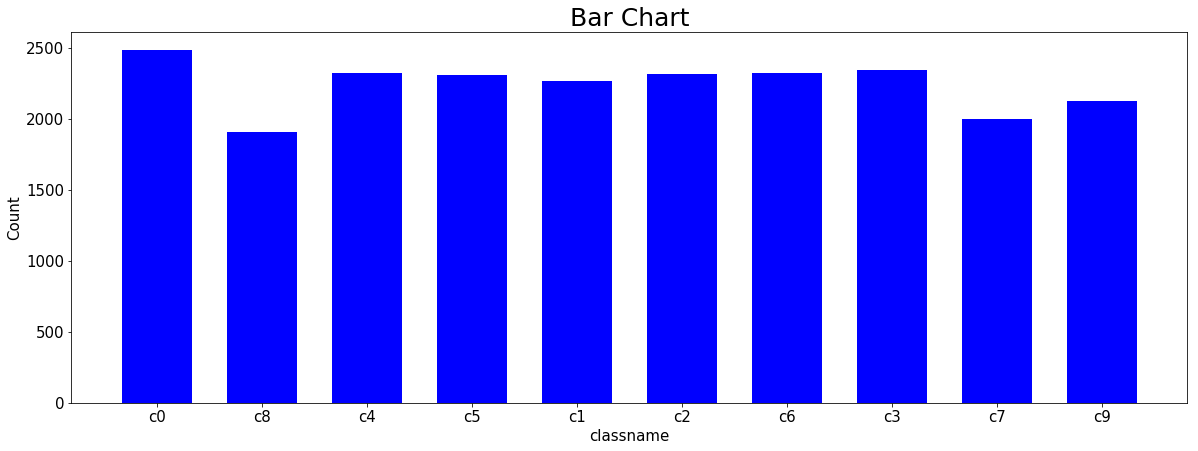

In [6]:
files = df['classname'].value_counts(sort=False)
labels = df['classname'].value_counts(sort=False).index.tolist()
y = np.array(files)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

### Pre-process the Data
When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$
where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

The path_to_tensor function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$
The paths_to_tensor function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape

$$
(\text{nb_samples}, 224, 224, 3).
$$
Here, nb_samples is the number of samples, or number of images, in the supplied array of image paths. It is best to think of nb_samples as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [7]:
!pip install tqdm

notebook 5.4.0 requires ipykernel, which is not installed.
jupyter 1.0.0 requires ipykernel, which is not installed.
jupyter-console 5.2.0 requires ipykernel, which is not installed.
ipywidgets 7.1.1 requires ipykernel>=4.5.1, which is not installed.
Cache entry deserialization failed, entry ignored


In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL.Image import Image

In [9]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

The images are rescaled by dividing every pixel in every image by 255. 0.5 is subtracted to ensure the mean is zero.

In [10]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True  

In [11]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255 - 0.5


100%|██████████| 4485/4485 [00:36<00:00, 122.29it/s]


In [12]:
train_tensors.shape

(17939, 224, 224, 3)

In [13]:
valid_tensors.shape

(4485, 224, 224, 3)

## Train a CNN with Transfer Learning
To reduce training time without sacrificing accuracy, a CNN is trained using transfer learning.

### Using the bottleneck features of a pre-trained network¶


### Obtain Bottleneck Features

In [14]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [15]:
bottleneck_features_train_VGG16 = np.asarray([model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in train_tensors],dtype=np.float32)

In [16]:
np.save(open('bottleneck_features/bottleneck_features_train_VGG16.npy', 'wb'),bottleneck_features_train_VGG16)

In [17]:
bottleneck_features_valid_VGG16 = np.asarray([model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in valid_tensors],dtype=np.float32)
np.save(open('bottleneck_features/bottleneck_features_valid_VGG16.npy', 'wb'),bottleneck_features_valid_VGG16)

In [18]:
print(bottleneck_features_train_VGG16.shape)
print(bottleneck_features_valid_VGG16.shape)

(17939, 7, 7, 512)
(4485, 7, 7, 512)


In [19]:
bottleneck_features_train_VGG16 = np.load('bottleneck_features/bottleneck_features_train_VGG16.npy')
bottleneck_features_valid_VGG16 = np.load('bottleneck_features/bottleneck_features_valid_VGG16.npy')

### Model Architecture
The model uses the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model. We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each driver category and is equipped with a softmax.

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras import backend as K
import numpy as np
from keras.callbacks import ModelCheckpoint 
from keras.callbacks import EarlyStopping
import h5py

In [21]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=bottleneck_features_train_VGG16.shape[1:]))
VGG16_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [22]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [23]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1', 
                               verbose=1, save_best_only=True)

In [24]:
earlystop =  EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [25]:
history = VGG16_model.fit(bottleneck_features_train_VGG16, train_targets, 
          validation_data=(bottleneck_features_valid_VGG16, valid_targets),
          epochs=150,batch_size= 32, callbacks=[checkpointer,earlystop], verbose=2)
score = VGG16_model.evaluate(bottleneck_features_valid_VGG16, valid_targets, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 17939 samples, validate on 4485 samples
Epoch 1/150
 - 8s - loss: 2.1196 - acc: 0.3255 - val_loss: 1.9559 - val_acc: 0.4700

Epoch 00001: val_loss improved from inf to 1.95593, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 2/150
 - 7s - loss: 1.8168 - acc: 0.5616 - val_loss: 1.6980 - val_acc: 0.5893

Epoch 00002: val_loss improved from 1.95593 to 1.69803, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 3/150
 - 7s - loss: 1.5905 - acc: 0.6499 - val_loss: 1.4974 - val_acc: 0.6874

Epoch 00003: val_loss improved from 1.69803 to 1.49736, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 4/150
 - 6s - loss: 1.4121 - acc: 0.7113 - val_loss: 1.3389 - val_acc: 0.7289

Epoch 00004: val_loss improved from 1.49736 to 1.33886, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 5/150
 - 7s - loss: 1.2697 - acc: 0.7515 - val_loss: 1.2095 - val_acc

Epoch 00037: val_loss improved from 0.29535 to 0.29285, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 38/150
 - 8s - loss: 0.2892 - acc: 0.9455 - val_loss: 0.2834 - val_acc: 0.9483

Epoch 00038: val_loss improved from 0.29285 to 0.28335, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 39/150
 - 8s - loss: 0.2824 - acc: 0.9478 - val_loss: 0.2790 - val_acc: 0.9489

Epoch 00039: val_loss improved from 0.28335 to 0.27901, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 40/150
 - 7s - loss: 0.2764 - acc: 0.9485 - val_loss: 0.2715 - val_acc: 0.9494

Epoch 00040: val_loss improved from 0.27901 to 0.27150, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 41/150
 - 7s - loss: 0.2710 - acc: 0.9502 - val_loss: 0.2677 - val_acc: 0.9494

Epoch 00041: val_loss improved from 0.27150 to 0.26773, saving model to saved_models/weights.best.VGG16.hdf5_transfe


Epoch 00076: val_loss improved from 0.16872 to 0.16470, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 77/150
 - 7s - loss: 0.1608 - acc: 0.9683 - val_loss: 0.1654 - val_acc: 0.9670

Epoch 00077: val_loss did not improve from 0.16470
Epoch 78/150
 - 7s - loss: 0.1589 - acc: 0.9686 - val_loss: 0.1632 - val_acc: 0.9643

Epoch 00078: val_loss improved from 0.16470 to 0.16324, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 79/150
 - 7s - loss: 0.1575 - acc: 0.9687 - val_loss: 0.1613 - val_acc: 0.9652

Epoch 00079: val_loss improved from 0.16324 to 0.16128, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 80/150
 - 7s - loss: 0.1555 - acc: 0.9699 - val_loss: 0.1599 - val_acc: 0.9681

Epoch 00080: val_loss improved from 0.16128 to 0.15995, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 81/150
 - 7s - loss: 0.1544 - acc: 0.9693 - val_loss: 0.15


Epoch 00119: val_loss improved from 0.12473 to 0.12083, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 120/150
 - 7s - loss: 0.1134 - acc: 0.9773 - val_loss: 0.1214 - val_acc: 0.9715

Epoch 00120: val_loss did not improve from 0.12083
Epoch 121/150
 - 7s - loss: 0.1125 - acc: 0.9780 - val_loss: 0.1202 - val_acc: 0.9706

Epoch 00121: val_loss improved from 0.12083 to 0.12025, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 122/150
 - 7s - loss: 0.1118 - acc: 0.9779 - val_loss: 0.1221 - val_acc: 0.9715

Epoch 00122: val_loss did not improve from 0.12025
Epoch 123/150
 - 7s - loss: 0.1112 - acc: 0.9776 - val_loss: 0.1183 - val_acc: 0.9724

Epoch 00123: val_loss improved from 0.12025 to 0.11831, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning_final_1
Epoch 124/150
 - 7s - loss: 0.1106 - acc: 0.9783 - val_loss: 0.1177 - val_acc: 0.9735

Epoch 00124: val_loss improved from 0.11831 to 0.11770, s

In [26]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [28]:
epoch = np.arange(len(acc))

[Text(0,0.5,'Loss'), Text(0.5,0,'Epochs')]

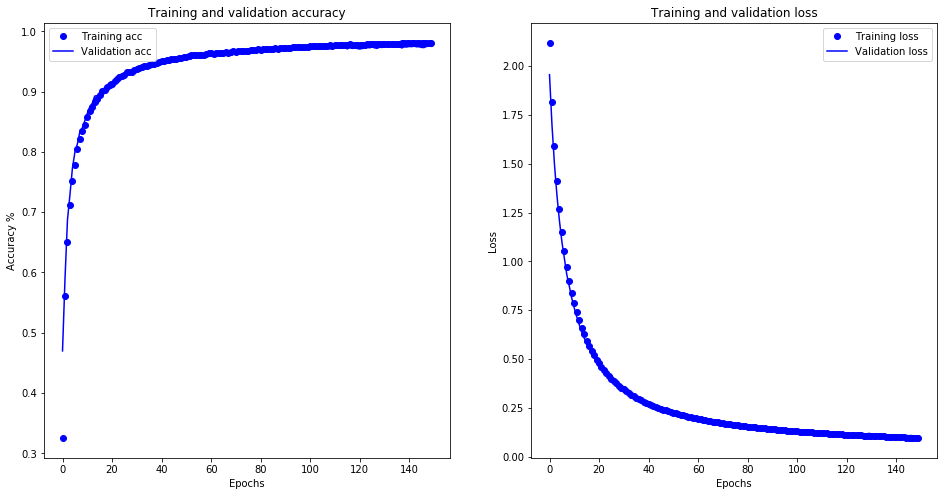

In [29]:
fig, axes = plt.subplots(1,2,figsize=(16,8))

axes[0].plot(epoch, acc, 'bo', label='Training acc')
axes[0].plot(epoch, val_acc, 'b', label='Validation acc')
axes[0].set_title('Training and validation accuracy')
axes[0].legend()
axes[0].set(xlabel='Epochs', ylabel='Accuracy %')
axes[1].plot(epoch, loss, 'bo', label='Training loss')
axes[1].plot(epoch, val_loss, 'b', label='Validation loss')
axes[1].set_title('Training and validation loss')
axes[1].legend()
axes[1].set(xlabel='Epochs', ylabel='Loss')
#plt.savefig('Evaluation_grapgh.png')

In [30]:
#from keras.models import load_model

In [31]:
# new_model = load_model('saved_models/weights.best.VGG16.hdf5_transfer_learning')

### Load the Model with the Best Validation Loss

In [32]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5_transfer_learning_final')

### Validate the Model

Predict the validation targets and cross verify the predicted values with ground truth

In [33]:
VGG16_valid_pred = [VGG16_model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in bottleneck_features_valid_VGG16]

In [34]:
VGG16_valid_pred

[array([2.5536589e-05, 9.1425227e-06, 6.9073017e-06, 9.9885929e-01,
        6.1800145e-04, 1.9558829e-05, 7.9533146e-07, 4.8509446e-07,
        2.5541156e-06, 4.5784281e-04], dtype=float32),
 array([4.5247278e-01, 1.4600511e-04, 1.6341569e-04, 4.3662008e-02,
        2.5001651e-01, 1.8974741e-01, 2.1861088e-05, 1.1739170e-06,
        5.9427766e-05, 6.3709378e-02], dtype=float32),
 array([1.2642481e-08, 5.8765698e-07, 1.5758586e-06, 1.6641789e-05,
        2.2670249e-03, 4.3272306e-07, 2.5804932e-04, 9.9549341e-01,
        1.9441404e-03, 1.8190345e-05], dtype=float32),
 array([1.9807627e-05, 1.2525206e-04, 6.0111135e-02, 5.8024707e-06,
        2.4427265e-05, 4.0283889e-05, 2.2752339e-02, 7.0099481e-03,
        9.0868646e-01, 1.2245665e-03], dtype=float32),
 array([9.94897746e-08, 1.10588800e-04, 6.71814462e-07, 5.60958688e-05,
        1.15433664e-04, 9.97808874e-01, 4.32273118e-05, 1.37452503e-06,
        3.46791603e-06, 1.86024955e-03], dtype=float32),
 array([1.6602408e-03, 1.5876682e-0

In [35]:
VGG16_valid_pred[0]

array([2.5536589e-05, 9.1425227e-06, 6.9073017e-06, 9.9885929e-01,
       6.1800145e-04, 1.9558829e-05, 7.9533146e-07, 4.8509446e-07,
       2.5541156e-06, 4.5784281e-04], dtype=float32)

In [36]:
valid_targets[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [37]:
np.argmax(VGG16_valid_pred, axis=1)

array([3, 0, 7, ..., 8, 9, 9], dtype=int64)

In [38]:
np.argmax(valid_targets, axis=1)

array([3, 0, 7, ..., 8, 9, 9], dtype=int64)

### Import required evaluation metrics from scikit learn
- valid_targets is the ground truth of validation data
- VGG16_valid_pred is the predicted value of validation data using above model

In [39]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

In [40]:
cm = confusion_matrix(np.argmax(valid_targets, axis=1), np.argmax(VGG16_valid_pred, axis=1))

In [42]:
precision_score(np.argmax(valid_targets,axis = 1),np.argmax(VGG16_valid_pred,axis=1),average='macro')

0.9740008360211221

In [43]:
precision_score(np.argmax(valid_targets,axis = 1),np.argmax(VGG16_valid_pred,axis=1),average='micro')

0.9741360089186176

In [44]:
precision_score(np.argmax(valid_targets,axis = 1),np.argmax(VGG16_valid_pred,axis=1),average='weighted')

0.9741438717737992

In [45]:
recall_score(np.argmax(valid_targets,axis = 1),np.argmax(VGG16_valid_pred,axis=1),average='macro')

0.9732096849328874

In [46]:
recall_score(np.argmax(valid_targets,axis = 1),np.argmax(VGG16_valid_pred,axis=1),average='micro')

0.9741360089186176

In [47]:
recall_score(np.argmax(valid_targets,axis = 1),np.argmax(VGG16_valid_pred,axis=1),average='weighted')

0.9741360089186176

In [48]:
accuracy_score(np.argmax(valid_targets, axis=1), np.argmax(VGG16_valid_pred, axis=1))

0.9741360089186176

### Plot Confusion Matrix

In [49]:
import itertools

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.savefig('Confusion_matrix.png')

Confusion matrix, without normalization


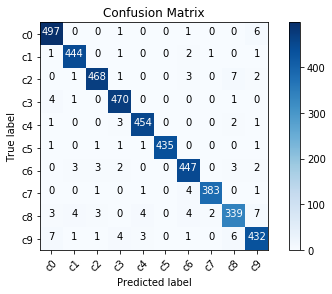

In [51]:
cm_plot_labels = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Test the Model
Get the test image data using Imagedatagenerator with batch wise to over come memory issues

In [52]:
from keras.preprocessing.image import ImageDataGenerator

In [53]:
batch_size = 32

In [54]:
test_path = 'imgs/test_imgs'

In [55]:
test_batch = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path, target_size= (224,224),batch_size= batch_size,shuffle=False)

Found 79726 images belonging to 1 classes.


In [56]:
len(test_batch.filenames)

79726

Directly predict_generator can be used to predict the test batch which created using the ImageDataGenerator. But still facing the memory issues due to heavy image count of test data. So following below method as a work around to predict the test data.

In [57]:
filenames = []
VGG16_predictions = []
for i,batch in enumerate(test_batch):
    filenames += test_batch.filenames[i*batch_size: (i+1) * batch_size]
    bottleneck_features_test_VGG16 = np.asarray([model.predict(batch[0])],dtype=np.float32)
    s1,s2,s3,s4,s5 = bottleneck_features_test_VGG16.shape
    bottleneck_features_test_VGG16 = bottleneck_features_test_VGG16.reshape(s2,s3,s4,s5)
    VGG16_predictions += [VGG16_model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in bottleneck_features_test_VGG16]    
    if (i+1) * batch_size >= len(test_batch.filenames):
        break
    #print(i)

In [58]:
len(VGG16_predictions)

79726

In [59]:
len(filenames)

79726

In [60]:
filenames[0]

'test\\img_1.jpg'

Prepare the data for Kaggle submission

In [61]:
test_files_final = [item_test.replace('test\\','') for item_test in filenames]

In [62]:
VGG16_subm = np.column_stack((np.asarray(test_files_final), np.asarray(np.round_(VGG16_predictions,decimals =3, out= None),dtype=np.float32)))

In [63]:
np.savetxt('kaggle_submissions/VGG16_submission_final.csv',VGG16_subm, delimiter=',',comments='', newline='\n', fmt='%s', header = 'img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9')

In [144]:
VGG16_subm

array([['img_1.jpg', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ['img_10.jpg', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ['img_100.jpg', '0.988', '0.012', ..., '0.0', '0.0', '0.0'],
       ...,
       ['img_99996.jpg', '0.001', '0.0', ..., '0.0', '0.0', '0.0'],
       ['img_99998.jpg', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ['img_99999.jpg', '0.0', '0.0', ..., '0.0', '0.0', '0.0']],
      dtype='<U32')

### To predict individual test image

In [97]:
import os
import cv2

In [98]:
os.getcwd()

'C:\\Users\\Jhansi\\Desktop\\Capstone_project_revised'

In [203]:
path = r'imgs\test_imgs'

In [208]:
def img_prediction(img_name):
    img = plt.imread(os.path.join(path, 'test',img_name))
    img = cv2.resize(img,(224,224))
    plt.imshow(img)
    test_tensor = path_to_tensor(path+"\\test\\"+img_name).astype('float32')/255 - 0.5
    bottleneck_features_test_VGG16 = np.asarray([model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in test_tensor],dtype=np.float32)
    prediction = [VGG16_model.predict(np.expand_dims(tensor, axis=0))[0] for tensor in bottleneck_features_test_VGG16] 
    if(np.argmax(prediction,axis = 1) == 0):
        print("Driving with attention")
    else:
        print("Driver is distracted")

Driver is distracted


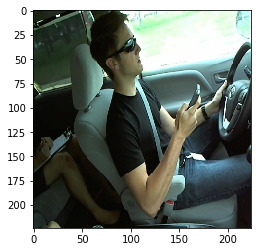

In [209]:
img_prediction('img_159.jpg')

Driving with attention


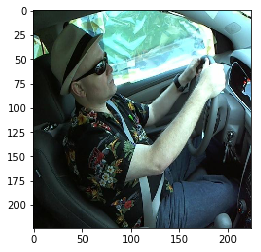

In [210]:
img_prediction('img_100.jpg')

### Model Architecture2
The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to the model. And add a Flatten layer and two fully connected layers.The last fully connected layer contains one node for each driver category and is equipped with a softmax.

In [64]:
bottleneck_features_train2_VGG16 = np.load('bottleneck_features/bottleneck_features_train_VGG16.npy')
bottleneck_features_valid2_VGG16 = np.load('bottleneck_features/bottleneck_features_valid_VGG16.npy')

In [65]:
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [73]:
VGG16_model2 = Sequential()
VGG16_model2.add(Flatten(input_shape=bottleneck_features_train2_VGG16.shape[1:]))
VGG16_model2.add(Dense(256, activation='relu',kernel_initializer='glorot_normal'))
VGG16_model2.add(Dropout(0.5))
VGG16_model2.add(Dense(10, activation='softmax',kernel_initializer='glorot_normal'))

VGG16_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                2570      
Total params: 6,425,354
Trainable params: 6,425,354
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [74]:
VGG16_model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [75]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5_transfer_learning2', 
                               verbose=1, save_best_only=True)
earlystop =  EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

hist = VGG16_model2.fit(bottleneck_features_train2_VGG16, train_targets, 
          validation_data=(bottleneck_features_valid2_VGG16, valid_targets),
          epochs=100, batch_size=16, callbacks=[checkpointer,earlystop], verbose=2)
score = VGG16_model2.evaluate(bottleneck_features_valid2_VGG16, valid_targets, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 17939 samples, validate on 4485 samples
Epoch 1/100
 - 18s - loss: 1.4159 - acc: 0.6110 - val_loss: 0.1419 - val_acc: 0.9643

Epoch 00001: val_loss improved from inf to 0.14189, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning2
Epoch 2/100
 - 18s - loss: 0.4409 - acc: 0.8521 - val_loss: 0.0858 - val_acc: 0.9732

Epoch 00002: val_loss improved from 0.14189 to 0.08582, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning2
Epoch 3/100
 - 18s - loss: 0.3545 - acc: 0.8898 - val_loss: 0.0456 - val_acc: 0.9882

Epoch 00003: val_loss improved from 0.08582 to 0.04561, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning2
Epoch 4/100
 - 18s - loss: 0.3297 - acc: 0.9017 - val_loss: 0.0365 - val_acc: 0.9906

Epoch 00004: val_loss improved from 0.04561 to 0.03651, saving model to saved_models/weights.best.VGG16.hdf5_transfer_learning2
Epoch 5/100
 - 18s - loss: 0.2983 - acc: 0.9169 - val_loss: 0.0556 - val_acc: 0.9833

Epoch 00005: 

In [76]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

In [77]:
epoch = np.arange(len(acc))

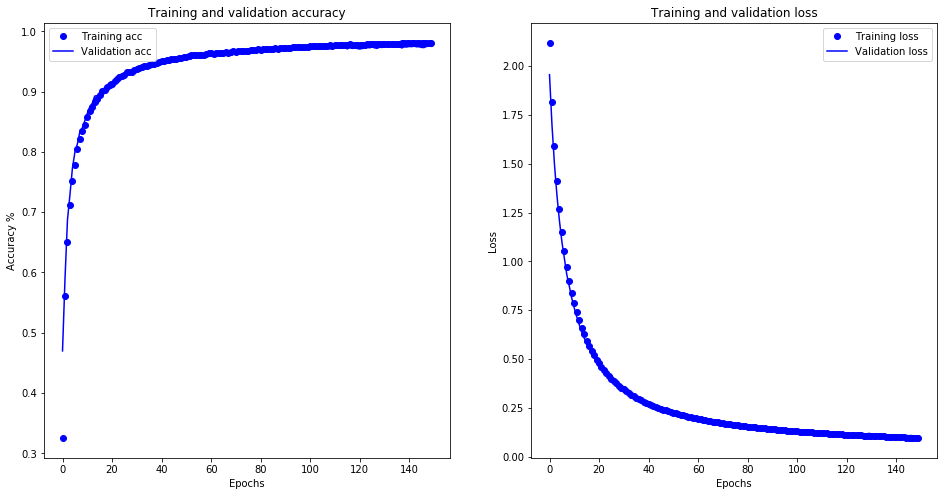

In [78]:
fig, axes = plt.subplots(1,2,figsize=(16,8))

axes[0].plot(epoch, acc, 'bo', label='Training acc')
axes[0].plot(epoch, val_acc, 'b', label='Validation acc')
axes[0].set_title('Training and validation accuracy')
axes[0].legend()
axes[0].set(xlabel='Epochs', ylabel='Accuracy %')
axes[1].plot(epoch, loss, 'bo', label='Training loss')
axes[1].plot(epoch, val_loss, 'b', label='Validation loss')
axes[1].set_title('Training and validation loss')
axes[1].legend()
axes[1].set(xlabel='Epochs', ylabel='Loss')
plt.savefig('Evaluation_grapgh_model2.png')

### Load the Model with best validation loss

In [79]:
VGG16_model2.load_weights('saved_models/weights.best.VGG16.hdf5_transfer_learning2')

In [80]:
VGG16_2_valid_pred = [VGG16_model2.predict(np.expand_dims(tensor, axis=0))[0] for tensor in bottleneck_features_valid2_VGG16]

In [81]:
confusion_matrix(np.argmax(valid_targets, axis=1), np.argmax(VGG16_2_valid_pred, axis=1))

array([[503,   1,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0, 449,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0, 480,   0,   0,   0,   0,   0,   2,   0],
       [  3,   0,   0, 473,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 461,   0,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0, 438,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0, 456,   0,   1,   2],
       [  0,   2,   0,   0,   0,   0,   0, 388,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0, 363,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 455]], dtype=int64)

In [82]:
accuracy_score(np.argmax(valid_targets, axis=1), np.argmax(VGG16_2_valid_pred, axis=1))

0.9957636566332219

In [83]:
precision_score(np.argmax(valid_targets,axis = 1),np.argmax(VGG16_2_valid_pred,axis=1),average='micro')

0.9957636566332219

In [84]:
recall_score(np.argmax(valid_targets,axis = 1),np.argmax(VGG16_2_valid_pred,axis=1),average='micro')

0.9957636566332219

In [92]:
filenames_2= []
VGG16_predictions_2 = []
for i,batch in enumerate(test_batch):
    filenames_2 += test_batch.filenames[i*batch_size: (i+1) * batch_size]
    bottleneck_features_test_VGG16 = np.asarray([model.predict(batch[0])],dtype=np.float32)
    s1,s2,s3,s4,s5 = bottleneck_features_test_VGG16.shape
    bottleneck_features_test_VGG16 = bottleneck_features_test_VGG16.reshape(s2,s3,s4,s5)
    VGG16_predictions_2 += [VGG16_model2.predict(np.expand_dims(tensor, axis=0))[0] for tensor in bottleneck_features_test_VGG16]    
    if (i+1) * batch_size >= len(test_batch.filenames):
        break
    #print(i)

In [94]:
test_files_final = [item_test.replace('test\\','') for item_test in filenames_2]

In [93]:
len(filenames_2)

79726

In [95]:
VGG16_subm = np.column_stack((np.asarray(test_files_final), np.asarray(np.round_(VGG16_predictions_2,decimals =3, out= None),dtype=np.float32)))

In [96]:
np.savetxt('kaggle_submissions/VGG16_submission_final_2.csv',VGG16_subm, delimiter=',',comments='', newline='\n', fmt='%s', header = 'img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9')